In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#__Fine-tuning a Pretrained Convolutional Neural Network (CNN) for fine-grained categoriztaion of an image__


* AlexNet was the winner of ImageNet challenge in 2012. Proposed by Alex Krizevsky, Ilya Sutskever, and Geofrey Hinton from University of Toronto.

* VGG was the winner of ImageNet (1000-class image classification) challenge in 2014. Proposed by Andrew Zisserman's group in Oxford University.

* ResNet was the winner of ImageNet challenge in 2015. Proposed by Kaiming He et al. from Microsoft Research.


[AlexNet: A. Krizhevsky, I. Sutskever, and G. Hinton, ImageNet Classification with Deep Convolutional Neural Networks, NIPS 2012](www.cs.toronto.edu/~fritz/absps/imagenet.pdf)

[VGG: Very Deep Convolutional Networks for Large-Scale Image Recognition - Karen Simonyan and Andrew Zisserman](https://arxiv.org/abs/1409.1556)

[ResNet: Deep Residual Learning for Image Recognition - Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/abs/1409.1556)



#__Bird Species: dataset visualization__
Download the dataset from the following link:

- [Bird Species Dataset](https://analytics.drake.edu/~reza/teaching/cs167_sp24/dataset/bird_species_v1.zip)
  - Each image size: __WxHx3__
    - Note that these are color images
  
<!--div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_fall23/notes/images/cifar-10-sprite.png" width=500/>
</div-->

# **Model 1: AlexNet for fine-tuning and evaluating**

Using cuda device
Size of train set: 1227
Size of test set: 125


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 127MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

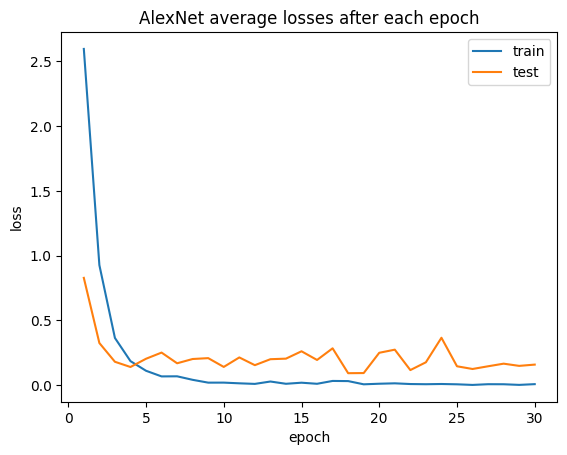

SimpleRNNv1 model has been trained!


In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb
from scipy.io import savemat

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Step 2: load the dataset
#--------------------------------------------------------------------------------------------------
# For fine-tuning with an AlexNet/VGG/ResNet architecture that has been pre-trained using the ImageNet dataset, you need to normalize
# each image with the given mean and standard deviation.
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((.229, .224, .225), (.485, .456, .406)) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])


train_dir       = '/content/drive/MyDrive/Machine Learning/datasets/bird_species_v1/bird_species_v1/train'
test_dir        = '/content/drive/MyDrive/Machine Learning/datasets/bird_species_v1/bird_species_v1/test'

train_dataset   = datasets.ImageFolder(train_dir, transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.

N_train         = len(train_dataset)
N_test          = len(test_dataset)

number_of_classes = 25                    # Headsup! You should change this to the appropriate number when you fine-tune your model on a different dataset.

print("Size of train set:", N_train)
print("Size of test set:",  N_test)


# Step 3: Use the AlexNet from above
#--------------------------------------------------------------------------------------------------

# You can give any name to your new network, e.g., AlexNet.
# You should load the pretrained AlexNet model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'


class AlexNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AlexNet, self).__init__()
        net = models.alexnet(pretrained=True)

        # retained earlier convolutional and pooling layers from AlexNet
        self.features   = net.features
        self.avgpool    = net.avgpool

        # added new fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        #print("shape of input: ", x.shape)
        x = self.features(x)
        #print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        #print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #print("output shape (self.classifier): ", x.shape)
        return x


# Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer, save_path):

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)

    model.train()                   # set the model to training mode for best practices

    train_loss      = 0
    correct         = 0
    train_pred_all  = []
    train_y_all     = []
    best_accuracy = 0

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # compute the accuracy
        pred_prob   = softmax(pred)
        pred_y 			= torch.max(pred_prob, 1)[1]
        train_correct = (pred_y == y).sum()
        correct    += train_correct.data

        train_pred_all.append(pred_y) # save predicted output for the current batch
        train_y_all.append(y)         # save ground truth for the current batch

    #pdb.set_trace()
    train_pred_all = torch.cat(train_pred_all) # need to concatenate batch-wise appended items
    train_y_all = torch.cat(train_y_all)

    train_loss = train_loss/num_batches
    correct    = correct.cpu().numpy()/size

    print('Confusion matrix for training set:\n', confusion_matrix(train_y_all.cpu().data, train_pred_all.cpu().data))

    accuracy = 100 * correct
    if accuracy > best_accuracy:
      torch.save(model.state_dict(), save_path)

    return train_loss, 100*correct


def test_loop(dataloader, model, loss_fn):

    model.eval()                    # set the model to evaluation mode for best practices

    size                = len(dataloader.dataset)
    num_batches         = len(dataloader)
    test_loss, correct  = 0, 0
    test_pred_all       = []
    test_y_all          = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():

      for X, y in dataloader:

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        test_loss += loss_fn(pred, y).item()

        # calculate probability and save the outputs for confusion matrix computation
        pred_prob     = softmax(pred)
        pred_y        = torch.max(pred_prob, 1)[1]
        test_correct  = (pred_y == y).sum()
        correct      += test_correct.data

        test_pred_all.append(pred_y) # save predicted output for the current batch
        test_y_all.append(y)         # save ground truth for the current batch


    #pdb.set_trace()
    test_pred_all = torch.cat(test_pred_all)
    test_y_all = torch.cat(test_y_all)

    test_loss = test_loss/num_batches
    correct   = correct.cpu().numpy()/size
    print(f"Test Performance: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print('Confusion matrix for test set:\n', confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data))
    return test_loss, 100*correct, confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data)

# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

cnn_model = AlexNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = 1e-4
batch_size_val    = 32
epochs            = 30
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []

save_path      = '/content/drive/MyDrive/Machine Learning/Models/alexnet_model_.pth'
loss_save_path = '/content/drive/MyDrive/Machine Learning/Models/alexnet_model__losses.mat'

start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer, save_path)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("AlexNet model has been fine-tuned!")
print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('AlexNet average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

print("SimpleRNNv1 model has been trained!")
savemat(loss_save_path, {'train_losses':train_losses})


                          ABBOTTS BABBLER  AMETHYST WOODSTAR  \
ABBOTTS BABBLER                         5                  0   
AMETHYST WOODSTAR                       0                  5   
ASIAN CRESTED IBIS                      0                  0   
AZURE JAY                               0                  0   
BARN SWALLOW                            0                  0   
BELTED KINGFISHER                       0                  0   
CASSOWARY                               0                  0   
CHINESE POND HERON                      0                  0   
CHUCAO TAPACULO                         0                  0   
CREAM COLORED WOODPECKER                0                  0   
CRESTED FIREBACK                        0                  0   
CRIMSON SUNBIRD                         0                  0   
DALMATIAN PELICAN                       0                  0   
EASTERN BLUEBIRD                        0                  0   
GLOSSY IBIS                             

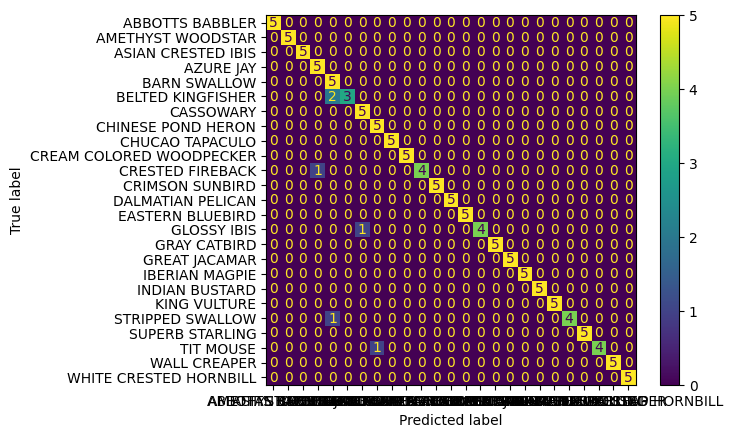

In [ ]:
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix
print(pandas.DataFrame(conf_matrix_test, index = dataset_labels, columns = dataset_labels))

displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

# **Model 2: VGGNet for fine-tuning and evaluating**

Using cuda device
Size of train set: 1227
Size of test set: 125


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 62.3MB/s]


VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

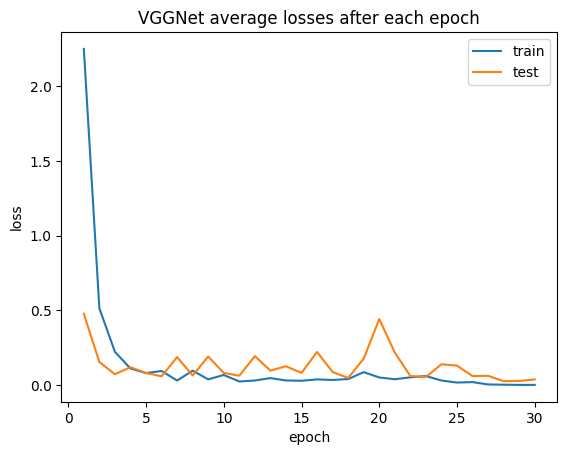

SimpleRNNv1 model has been trained!


In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb
from scipy.io import savemat

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Step 2: load the dataset
#--------------------------------------------------------------------------------------------------
# For fine-tuning with an AlexNet/VGG/ResNet architecture that has been pre-trained using the ImageNet dataset, you need to normalize
# each image with the given mean and standard deviation.
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((.229, .224, .225), (.485, .456, .406)) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])


train_dir       = '/content/drive/MyDrive/Machine Learning/datasets/bird_species_v1/bird_species_v1/train'
test_dir        = '/content/drive/MyDrive/Machine Learning/datasets/bird_species_v1/bird_species_v1/test'

train_dataset   = datasets.ImageFolder(train_dir, transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.

N_train         = len(train_dataset)
N_test          = len(test_dataset)

number_of_classes = 25                    # Headsup! You should change this to the appropriate number when you fine-tune your model on a different dataset.

print("Size of train set:", N_train)
print("Size of test set:",  N_test)


# Step 3: Use the VGGNet from above
#--------------------------------------------------------------------------------------------------

# You can give any name to your new network, e.g., AlexNet.
# You should load the pretrained AlexNet model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'


class VGGNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, bn=False):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=True)

        self.features = net.features
        self.avgpool = net.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )
        #pdb.set_trace()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer, save_path):

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)

    model.train()                   # set the model to training mode for best practices

    train_loss      = 0
    correct         = 0
    train_pred_all  = []
    train_y_all     = []
    best_accuracy = 0
    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # compute the accuracy
        pred_prob   = softmax(pred)
        pred_y 			= torch.max(pred_prob, 1)[1]
        train_correct = (pred_y == y).sum()
        correct    += train_correct.data

        train_pred_all.append(pred_y) # save predicted output for the current batch
        train_y_all.append(y)         # save ground truth for the current batch

    #pdb.set_trace()
    train_pred_all = torch.cat(train_pred_all) # need to concatenate batch-wise appended items
    train_y_all = torch.cat(train_y_all)

    train_loss = train_loss/num_batches
    correct    = correct.cpu().numpy()/size

    print('Confusion matrix for training set:\n', confusion_matrix(train_y_all.cpu().data, train_pred_all.cpu().data))

    accuracy = 100 * correct
    if accuracy > best_accuracy:
      torch.save(model.state_dict(), save_path)

    return train_loss, 100*correct


def test_loop(dataloader, model, loss_fn):

    model.eval()                    # set the model to evaluation mode for best practices

    size                = len(dataloader.dataset)
    num_batches         = len(dataloader)
    test_loss, correct  = 0, 0
    test_pred_all       = []
    test_y_all          = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():

      for X, y in dataloader:

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        test_loss += loss_fn(pred, y).item()

        # calculate probability and save the outputs for confusion matrix computation
        pred_prob     = softmax(pred)
        pred_y        = torch.max(pred_prob, 1)[1]
        test_correct  = (pred_y == y).sum()
        correct      += test_correct.data

        test_pred_all.append(pred_y) # save predicted output for the current batch
        test_y_all.append(y)         # save ground truth for the current batch


    #pdb.set_trace()
    test_pred_all = torch.cat(test_pred_all)
    test_y_all = torch.cat(test_y_all)

    test_loss = test_loss/num_batches
    correct   = correct.cpu().numpy()/size
    print(f"Test Performance: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print('Confusion matrix for test set:\n', confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data))
    return test_loss, 100*correct, confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data)

# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

cnn_model = VGGNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = 1e-4
batch_size_val    = 32
epochs            = 30
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []

save_path      = '/content/drive/MyDrive/Machine Learning/Models/VGG_model_.pth'
loss_save_path = '/content/drive/MyDrive/Machine Learning/Models/VGG_model__losses.mat'

start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer, save_path)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("VGGNet model has been fine-tuned!")
print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('VGGNet average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

print("SimpleRNNv1 model has been trained!")
savemat(loss_save_path, {'train_losses':train_losses})


                          ABBOTTS BABBLER  AMETHYST WOODSTAR  \
ABBOTTS BABBLER                         5                  0   
AMETHYST WOODSTAR                       0                  5   
ASIAN CRESTED IBIS                      0                  0   
AZURE JAY                               0                  0   
BARN SWALLOW                            0                  0   
BELTED KINGFISHER                       0                  0   
CASSOWARY                               0                  0   
CHINESE POND HERON                      0                  0   
CHUCAO TAPACULO                         0                  0   
CREAM COLORED WOODPECKER                0                  0   
CRESTED FIREBACK                        0                  0   
CRIMSON SUNBIRD                         0                  0   
DALMATIAN PELICAN                       0                  0   
EASTERN BLUEBIRD                        0                  0   
GLOSSY IBIS                             

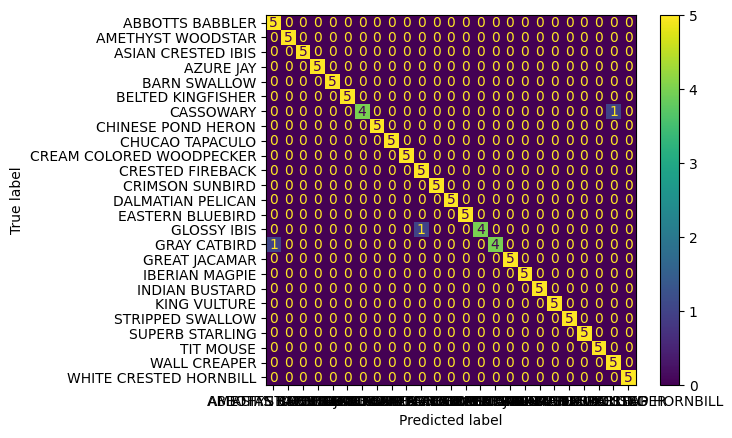

In [ ]:
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix
print(pandas.DataFrame(conf_matrix_test, index = dataset_labels, columns = dataset_labels))

displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

#__Model 3: ResNet for fine-tuning and evaluating__

Using cuda device
Size of train set: 1227
Size of test set: 125


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 82.8MB/s]


ResNet152(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

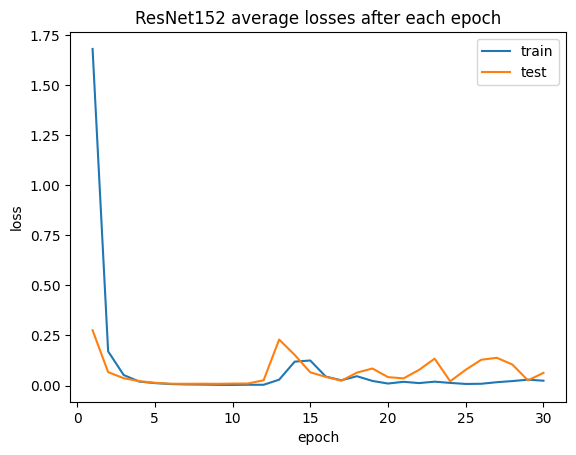

SimpleRNNv1 model has been trained!


In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb
from scipy.io import savemat

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Step 2: load the dataset
#--------------------------------------------------------------------------------------------------
# For fine-tuning with an AlexNet/VGG/ResNet architecture that has been pre-trained using the ImageNet dataset, you need to normalize
# each image with the given mean and standard deviation.
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((.229, .224, .225), (.485, .456, .406)) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])


train_dir       = '/content/drive/MyDrive/Machine Learning/datasets/bird_species_v1/bird_species_v1/train'
test_dir        = '/content/drive/MyDrive/Machine Learning/datasets/bird_species_v1/bird_species_v1/test'

train_dataset   = datasets.ImageFolder(train_dir, transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.

N_train         = len(train_dataset)
N_test          = len(test_dataset)

number_of_classes = 25                    # Headsup! You should change this to the appropriate number when you fine-tune your model on a different dataset.

print("Size of train set:", N_train)
print("Size of test set:",  N_test)


# Step 3: Use the VGGNet from above
#--------------------------------------------------------------------------------------------------

# You can give any name to your new network, e.g., AlexNet.
# You should load the pretrained AlexNet model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'


class ResNet152(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet152, self).__init__()
        net = models.resnet152(pretrained=True)

        num_features = net.fc.in_features
        net.fc = nn.Linear(num_features, num_classes)

        self.conv1 = net.conv1
        self.bn1 = net.bn1
        self.relu = net.relu
        self.maxpool = net.maxpool

        self.layer1 = net.layer1
        self.layer2 = net.layer2
        self.layer3 = net.layer3
        self.layer4 = net.layer4

        self.avgpool = net.avgpool
        self.fc = net.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x



# Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer, save_path):

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)

    model.train()                   # set the model to training mode for best practices

    train_loss      = 0
    correct         = 0
    train_pred_all  = []
    train_y_all     = []
    best_accuracy = 0

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # compute the accuracy
        pred_prob   = softmax(pred)
        pred_y 			= torch.max(pred_prob, 1)[1]
        train_correct = (pred_y == y).sum()
        correct    += train_correct.data

        train_pred_all.append(pred_y) # save predicted output for the current batch
        train_y_all.append(y)         # save ground truth for the current batch

    #pdb.set_trace()
    train_pred_all = torch.cat(train_pred_all) # need to concatenate batch-wise appended items
    train_y_all = torch.cat(train_y_all)

    train_loss = train_loss/num_batches
    correct    = correct.cpu().numpy()/size

    print('Confusion matrix for training set:\n', confusion_matrix(train_y_all.cpu().data, train_pred_all.cpu().data))

    accuracy = 100 * correct
    if accuracy > best_accuracy:
      torch.save(model.state_dict(), save_path)

    return train_loss, 100*correct


def test_loop(dataloader, model, loss_fn):

    model.eval()                    # set the model to evaluation mode for best practices

    size                = len(dataloader.dataset)
    num_batches         = len(dataloader)
    test_loss, correct  = 0, 0
    test_pred_all       = []
    test_y_all          = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():

      for X, y in dataloader:

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        test_loss += loss_fn(pred, y).item()

        # calculate probability and save the outputs for confusion matrix computation
        pred_prob     = softmax(pred)
        pred_y        = torch.max(pred_prob, 1)[1]
        test_correct  = (pred_y == y).sum()
        correct      += test_correct.data

        test_pred_all.append(pred_y) # save predicted output for the current batch
        test_y_all.append(y)         # save ground truth for the current batch


    #pdb.set_trace()
    test_pred_all = torch.cat(test_pred_all)
    test_y_all = torch.cat(test_y_all)

    test_loss = test_loss/num_batches
    correct   = correct.cpu().numpy()/size
    print(f"Test Performance: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print('Confusion matrix for test set:\n', confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data))
    return test_loss, 100*correct, confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data)

# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

cnn_model = ResNet152(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = 1e-4
batch_size_val    = 32
epochs            = 30
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []

save_path      = '/content/drive/MyDrive/Machine Learning/Models/ResNet_.pth'
loss_save_path = '/content/drive/MyDrive/Machine Learning/Models/ResNet__losses.mat'

start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer, save_path)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("ResNet152 model has been fine-tuned!")
print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('ResNet152 average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

print("SimpleRNNv1 model has been trained!")
savemat(loss_save_path, {'train_losses':train_losses})


                          ABBOTTS BABBLER  AMETHYST WOODSTAR  \
ABBOTTS BABBLER                         5                  0   
AMETHYST WOODSTAR                       0                  5   
ASIAN CRESTED IBIS                      0                  0   
AZURE JAY                               0                  0   
BARN SWALLOW                            0                  0   
BELTED KINGFISHER                       0                  0   
CASSOWARY                               0                  0   
CHINESE POND HERON                      0                  0   
CHUCAO TAPACULO                         0                  0   
CREAM COLORED WOODPECKER                0                  0   
CRESTED FIREBACK                        0                  0   
CRIMSON SUNBIRD                         0                  0   
DALMATIAN PELICAN                       0                  0   
EASTERN BLUEBIRD                        0                  0   
GLOSSY IBIS                             

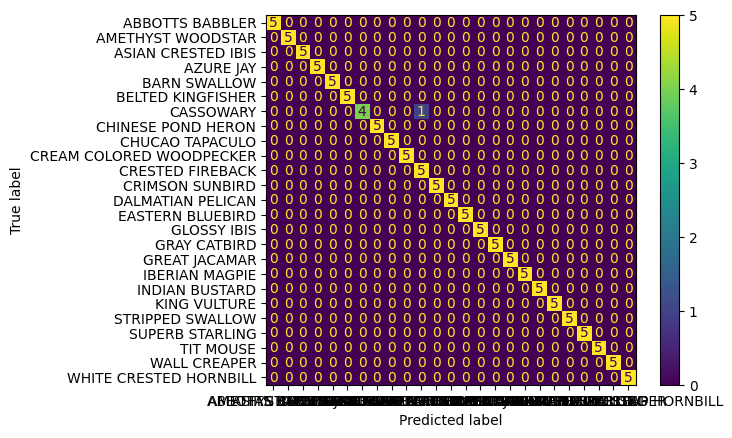

In [ ]:
dataset_labels = ['ABBOTTS BABBLER', 'AMETHYST WOODSTAR', 'ASIAN CRESTED IBIS', 'AZURE JAY', 'BARN SWALLOW', 'BELTED KINGFISHER', 'CASSOWARY', 'CHINESE POND HERON', 'CHUCAO TAPACULO', 'CREAM COLORED WOODPECKER', 'CRESTED FIREBACK', 'CRIMSON SUNBIRD', 'DALMATIAN PELICAN', 'EASTERN BLUEBIRD', 'GLOSSY IBIS', 'GRAY CATBIRD', 'GREAT JACAMAR', 'IBERIAN MAGPIE', 'INDIAN BUSTARD', 'KING VULTURE', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'TIT MOUSE', 'WALL CREAPER', 'WHITE CRESTED HORNBILL']

# your code goes here for building the confusion matrix
print(pandas.DataFrame(conf_matrix_test, index = dataset_labels, columns = dataset_labels))

displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

**Problem [1 point]: State the problem you are trying to solve with this machine learning experiment. Include a description of the data, and what you're trying to predict. What are the possible uses for this kind of machine learning model? Can this type of model be used for fine-grain categorization of any other domains such as biological, industrial, and personal.**\
\
This machine learning experiment aims to train 3 different model formats for image recognition of a variety of bird species. The data provided is labeled pictures of various birds. These general models can be used for other forms of image recognition within any scientific domain. Our particular trained models for example can be used to create an app for bird watching.

**Explore the Data [5 points]: Find the values for the following metrics:**

Total number of samples: total number of examples you have in the dataset\
1352\
\
Total number of training samples: total number of examples you have in the training split of the dataset\
1227\
\
Total number of testing samples: total number of examples you have in the testing split of the dataset\
125\
\
Number of classes: total number of categories in the dataset\
25\
\
Dimension of each data sample: Find the size of a sample image in the dataset (use the function .shape. \
227 x 227 (x 3 for the tensor)\
\
Refer to the Project_2_starter notebook which has sufficient hints.).


In [ ]:
N_train + N_test
N_train
N_test
train_dataset[0][0].shape

torch.Size([3, 227, 227])

**Data Preparation [1 point]: Explain your data preparation. What steps did you have to take to prepare your data for experiments, such as normalization, etc.? Which PyTorch function is responsible for performing the normalization? Just mention the name.**\
\
First, the images are resized to a square. Next, the images are converted to RGB tensors. Finally, the values are normalized with mean and standard deviation values. The function to do this normalization from pytorch is transforms.Normalize() (transforms is the variable).

**Metrics [1 point]: What metrics will you use to evaluate your model? Why are these metrics the best for your model? (Hint, this should be more than 'accuracy').**\
\
The test accuracy, average test loss, and confusion matrix are used to evaluate the 3 models. The learning plots at the end of the output can also be used to provide data about the average losses after each epoch.



**Model Planning and Execution [1 point]: Identify which learning algorithms you will try and which important parameters you will tune for each one. [Hint: you can find it from previous notebooks, such as Day22: CNN finetuning.**\
\
The learning algorithms being tested are Alexnet, VGG, and ResNet. The hyperparameters of these models are batch size, learning rate, and epoch.

**Bumps in the Road [1 point]: What challenges did you encounter? How did you overcome these challenges? Did you have to adapt your strategy to account for these challenges? Why or why not?**\
\
I think computing will always be a challenge as people try to make bigger and better models. I ran into some struggles with having enough T4 usage time, so I was forced to use a lower number of epochs (30) to train my models. I also overcame this by making a new google colab account. Otherwise, I would not have finished this project in time to wait for my allowed usage to go back up.

**Results [3 point]: After you conduct your learning experiment, summarize the results you got. Include visualizations as appropriate. More explicitly, you should fill in the following table:**\
\
The ResNet received the best results because it achieved 100% accuracy with a very small number of epochs. VGG received the same score, however, it did take longer to get there. AlexNet being the oldest model of the 3 performed the worst by only achieving a best performance of 97.60%. \

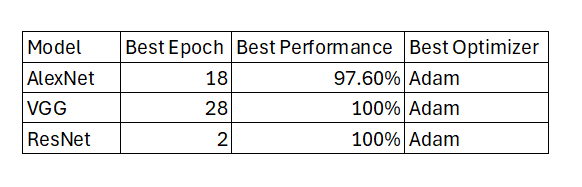

**Conclusions [1 point]: What insights/recommendations do you have? What did you find that was interesting? Which model was your best model? Why do you think models are giving excellent results from the first epoch? Do you need too many epochs to find your best? Why or why not? In general, I want a discussion of your experiment, the results, and what they mean.**\
\
All of the models had very accurate performances on the dataset with ResNet being the most accurate and AlexNet being the least accurate. I think it is interesting that these models are able to perform so well especially on a really low number of epochs, but it makes sense when considering that they were pretrained on the ImageNet dataset which greatly accerlates them learning other data. I would recommend training them on 30 epochs because it isn't very computationally heavy and 2 of the models were able to reach 100% by then. None of them would have benefitted from any more epochs because they were cycling between getting worse then getting better again.

**Extra Credit:**\
\
The confusion matrixes are loaded after each model and the models are saved. Here is a picture of them in my google drive saved as files:
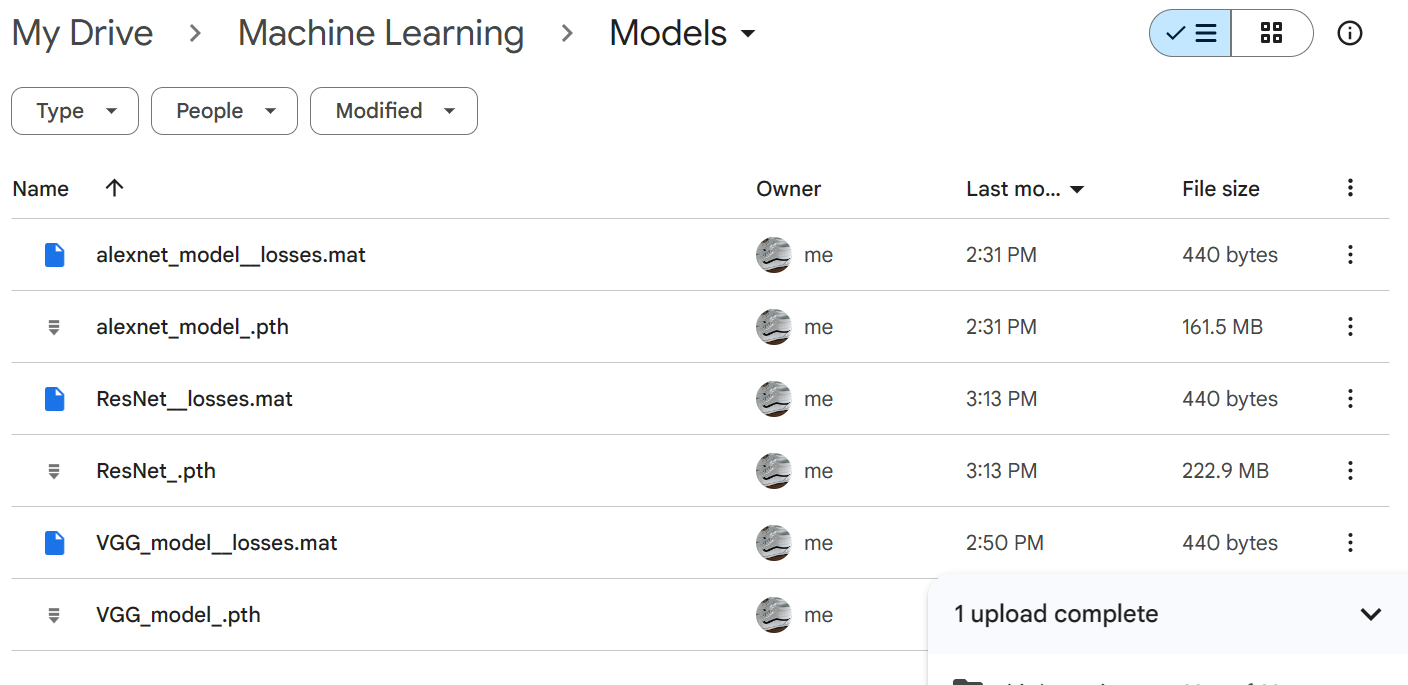
